In [ ]:
# %pip install -U scipy

In [ ]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# project_dir = "/codespace/braintypicality"
# sys.path.append(project_dir)

In [3]:
import re
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm

from functools import partial
from tqdm import tqdm
from scipy.stats import spearmanr, permutation_test, mannwhitneyu, PermutationMethod, false_discovery_control, rankdata
ATLAS = "AAL+CSF"
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

TEN_PERCENT = 0.1
FIVE_PERCENT = 0.05
ONE_PERCENT = 0.01

In [4]:
def statistic(x, y, dof, axis=0):  # explore all possible pairings by permuting `x`
    rs = spearmanr(x, y, axis=axis).statistic  # ignore pvalue
    transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
    return transformed

def run_correlation_analysis(samples,
                             behavior_cols,
                             roi_score_threshold_quantile=0.8,
                             relevant_roi_columns = None,
                             n_resamples=10_000):
    
    dof = len(samples) - 2

    msma_scores = samples[relevant_roi_columns]
    behavior_scores = samples[behavior_cols]
    pairs = [(r,b) for r in relevant_roi_columns for b in behavior_cols]

    print("Running permutation test ... ")
    print(f"Feature Pairs: {len(pairs)} from {len(relevant_roi_columns)} ROIs and {len(behavior_cols)} Behavior Scores")
    print(f"Maximum DOF: {dof} ")
    
    sigcorrs = []
    for (roi, bhv) in tqdm(pairs):
        x,y = samples[roi], samples[bhv]
        nonmissing = y > -1
        if nonmissing.sum() < 10: continue
        
        x,y = x[nonmissing], y[nonmissing]
        dof = len(x) - 2
        
        ref = permutation_test((x, ), partial(statistic, y=y, dof=dof), vectorized=False,
                               n_resamples=n_resamples, alternative='two-sided', permutation_type='pairings')
        corr = spearmanr(x, y).statistic
        sigcorrs.append((roi, bhv, corr, ref.pvalue, len(y)))
    
    sigcorrdf = pd.DataFrame(sigcorrs, columns=['ROI', "Behavior", "Corr", "p-value", "nsamples"])
    
    return sigcorrdf

## Loading Voxel-wise Scores

In [5]:
with open('data/aal-atlas-name-mapping.json', 'r') as file:
    short_to_desc = json.load(file)
short_to_desc['background'] = "Background"
short_to_desc['Frontal_Sup_Orb_L'] = 'Left Superior frontal gyrus, orbital part'
short_to_desc['Frontal_Sup_Orb_R'] = 'Right Superior frontal gyrus, orbital part'
short_to_desc['Parietal_Inf_L']    = 'Left Inferior parietal'
short_to_desc['Parietal_Inf_R']    = 'Right Inferior parietal'

In [6]:
roi_score_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_likelihoods.csv").rename(columns=short_to_desc)
roi_columns = roi_score_likelihoods.columns.difference(['Cohort', "ID"])
roi_score_likelihoods.describe()

,Background,CSF,Left Precentral gyrus,Right Precentral gyrus,"Left Superior frontal gyrus, dorsolateral","Right Superior frontal gyrus, dorsolateral","Left Superior frontal gyrus, orbital part","Right Superior frontal gyrus, orbital part",Left Middle frontal gyrus,Right Middle frontal gyrus,...,Left Lobule X of cerebellar hemisphere,Right Lobule X of cerebellar hemisphere,"Lobule I, II of vermis",Lobule III of vermis,"Lobule IV, V of vermis",Lobule VI of vermis,Lobule VII of vermis,Lobule VIII of vermis,Lobule IX of vermis,Lobule X of vermis
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,...,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,-52.319597,-0.377818,-16.516151,-16.224555,-13.818043,-14.786558,-7.952232,-7.362655,-14.798461,-14.637856,...,-3.204714,-2.568465,1.004282,-3.963514,-10.803113,-13.258068,-14.839645,-14.311450,-11.692039,1.828034
std,3.546803,1.228652,1.456727,1.556727,1.815214,1.858061,1.738513,1.847489,1.813877,1.835720,...,1.930059,2.248261,3.632817,2.708830,1.821178,2.177873,2.238607,1.970837,2.600565,2.952854
min,-56.578876,-2.319088,-18.865427,-19.293846,-16.664347,-17.834581,-11.162533,-10.705958,-17.992964,-17.878504,...,-8.171700,-6.777907,-7.101626,-11.365950,-14.709953,-17.588547,-18.750265,-18.642620,-16.613453,-5.228525
25%,-54.264077,-1.154375,-17.479531,-17.163305,-14.953725,-16.054201,-9.079662,-8.609350,-15.953917,-15.746493,...,-4.510982,-4.010949,-1.564713,-5.904717,-12.017765,-14.647789,-16.358936,-15.575236,-13.279220,-0.073873
50%,-53.372475,-0.594116,-16.710178,-16.546534,-14.171143,-15.222399,-8.296599,-7.697394,-15.106338,-15.056453,...,-3.428044,-3.018079,0.242059,-4.043064,-10.996241,-13.579793,-15.144185,-14.677023,-12.035291,1.782930
75%,-51.783491,-0.008909,-15.920045,-15.728770,-13.174180,-14.250692,-7.268675,-6.743108,-14.188337,-14.231890,...,-2.331557,-1.634686,3.056741,-2.266750,-9.938312,-12.436849,-13.679595,-13.352628,-10.477822,3.719014
max,-27.150005,7.890209,-5.713173,-5.071681,-2.370178,-3.197154,-0.232863,2.750425,-4.293357,-1.176398,...,4.721942,7.006848,13.638239,8.454497,0.980924,0.889772,-1.840893,-5.027266,1.283823,10.714840


In [7]:
aal_lobes = pd.read_csv('/ASD/ahsan_projects/braintypicality/dataset/aal_labels_lobe.csv', usecols=["ROI-Index", "ROI-Name", "Lobe"])
aal_lobes['Long-ROI-Names'] = [short_to_desc[r] for r in aal_lobes['ROI-Name']]
aal_lobes['Hemisphere'] = [l.split(" ")[1] for l in aal_lobes['Lobe']]

sorted_aal_lobes = aal_lobes.sort_values(by=['Hemisphere', 'Lobe', 'Long-ROI-Names'])

In [8]:
sorted_aal_lobes

,ROI-Index,ROI-Name,Lobe,Long-ROI-Names,Hemisphere
90,9001,Cerebelum_Crus1_L,Cerebellum L,Left Crus I of cerebellar hemisphere,L
92,9011,Cerebelum_Crus2_L,Cerebellum L,Left Crus II of cerebellar hemisphere,L
94,9021,Cerebelum_3_L,Cerebellum L,Left Lobule III of cerebellar hemisphere,L
96,9031,Cerebelum_4_5_L,Cerebellum L,"Left Lobule IV, V of cerebellar hemisphere",L
104,9071,Cerebelum_9_L,Cerebellum L,Left Lobule IX of cerebellar hemisphere,L
...,...,...,...,...,...
85,8202,Temporal_Mid_R,Temporal R,Right Middle temporal gyrus,R
39,4112,ParaHippocampal_R,Temporal R,Right Parahippocampal gyrus,R
81,8112,Temporal_Sup_R,Temporal R,Right Superior temporal gyrus,R
87,8212,Temporal_Pole_Mid_R,Temporal R,Right Temporal pole: middle temporal gyrus,R


In [9]:
lobe_ordered_rois = [r for r in sorted_aal_lobes['Long-ROI-Names'] if r in roi_columns]
lobe_ordered_rois = ['CSF'] + lobe_ordered_rois

In [10]:
reference_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/training-{ATLAS}_roi_likelihoods.csv").rename(columns=short_to_desc)
reference_likelihoods

,Background,CSF,Left Precentral gyrus,Right Precentral gyrus,"Left Superior frontal gyrus, dorsolateral","Right Superior frontal gyrus, dorsolateral","Left Superior frontal gyrus, orbital part","Right Superior frontal gyrus, orbital part",Left Middle frontal gyrus,Right Middle frontal gyrus,...,Left Lobule X of cerebellar hemisphere,Right Lobule X of cerebellar hemisphere,"Lobule I, II of vermis",Lobule III of vermis,"Lobule IV, V of vermis",Lobule VI of vermis,Lobule VII of vermis,Lobule VIII of vermis,Lobule IX of vermis,Lobule X of vermis
0,-52.405773,-1.160594,-16.240720,-15.420356,-13.174262,-14.156552,-7.823804,-4.615128,-14.945374,-14.115917,...,0.274043,-1.931260,-2.772257,-1.809489,-12.854198,-9.614663,-10.075984,-9.784621,-13.246734,-0.820748
1,-53.402084,0.589674,-16.218039,-16.240524,-12.814417,-14.059655,-6.404532,-6.504943,-14.161819,-14.106808,...,1.904382,0.368827,0.593147,-7.963304,-8.854574,-13.252735,-10.851413,-9.404264,-8.134412,2.729643
2,-53.377735,0.354789,-16.782894,-15.423598,-13.801647,-13.938385,-6.296635,-6.754046,-14.851440,-14.423994,...,-2.394596,1.226850,2.177078,-3.667122,-8.187992,-14.593800,-17.832844,-13.660639,-9.626647,7.527297
3,-53.366486,-1.123906,-14.828829,-16.024061,-11.564390,-11.740133,-6.887378,-7.011018,-13.014995,-13.505042,...,-2.102789,-4.208999,-5.066557,-7.836586,-11.836378,-15.871938,-17.315775,-16.632887,-13.647439,-0.835417
4,-54.079800,-0.805278,-15.471673,-15.820291,-12.870411,-12.842586,-9.030422,-6.099383,-14.213899,-13.620967,...,-1.462058,-2.483546,-0.818634,-7.150911,-14.199053,-14.393287,-9.442236,-8.504608,-10.238399,2.698345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,-56.249020,-2.643489,-16.350897,-16.684572,-14.756400,-15.867616,-9.001400,-8.668185,-15.575353,-16.849012,...,-4.610546,-2.590799,0.633469,-2.560068,-10.341605,-11.887557,-13.747066,-12.237647,-12.317142,3.320579
326,-52.580654,-0.585214,-14.549687,-15.862584,-13.132694,-13.948072,-9.040503,-7.104403,-13.877936,-14.395870,...,-5.449009,-3.158637,3.477614,-6.643682,-9.087432,-10.681849,-12.933929,-16.553982,-14.615436,0.704811
327,-51.015700,0.189976,-16.854430,-16.476469,-14.186939,-14.068050,-7.800881,-5.969154,-15.419061,-13.989452,...,-1.912146,-2.117533,1.705959,-4.996028,-10.097131,-12.048326,-11.650540,-12.399459,-10.757129,11.106877
328,-57.438920,-2.173401,-17.137371,-16.613934,-14.874028,-15.464175,-9.022839,-10.262229,-17.379310,-15.883713,...,-2.271553,-4.780619,-0.245777,-5.563844,-11.853545,-11.206584,-15.898020,-15.389916,-9.948182,3.416188


### Full names are adopted from various sources:

#### CBCL
- https://www.parinc.com/docs/default-source/product-resources/sample_c15.pdf
- http://crisisresponse.promoteprevent.org/webfm_send/2475

#### DAS
- https://www.myschoolpsychology.com/wp-content/uploads/2014/02/Differential-Ability-Scales.pdf

#### Vineland-II
- https://www.ualberta.ca/en/community-university-partnership/media-library/community-university-partnership/resources/tools---assessment/vinelandjune-2012.pdf

In [11]:
behavior_column_map = {
    
  "CBCL-aggr_behav_score": "CBCL-Aggressive Behavior",
  "CBCL-anx_prob_score": "CBCL-Anxiety Problems",
  "CBCL-anxious_score": "CBCL-Anxious/Depressed",
  "CBCL-attention_hyper_prob_score": "CBCL-Attention Deficit/Hyperactivity Problems",
  "CBCL-attention_prob_score": "CBCL-Attention Problems",
  "CBCL-conduct_prob_score": "CBCL-Conduct Problems",
  "CBCL-depressed_score": "CBCL-Withdrawn/Depressed",
  "CBCL-depressive_prob_score": "CBCL-Depressive Problems",
  "CBCL-externalizing_score": "CBCL-Externalizing Problems",
  "CBCL-internalizing_score": "CBCL-Internalizing Problems",
  "CBCL-obsessive_comp_prob_score": "CBCL-Obsessive-Compulsive Problems",
  "CBCL-oppo_def_prob_score": "CBCL-Oppositional Defiant Problems",
  "CBCL-rule_break_behav_score": "CBCL-Rule-Breaking Behavior",
  "CBCL-sluggish_cogn_tempo_score": "CBCL-Sluggish Cognitive Tempo",
  "CBCL-social_prob_score": "CBCL-Social Problems",
  "CBCL-som_comp_score": "CBCL-Somatic Complaints",
  "CBCL-som_prob_score": "CBCL-Somatic Problems",
  "CBCL-stress_prob_score": "CBCL-Stress Problems",
  "CBCL-thought_prob_score": "CBCL-Thought Problems",
  "CBCL-total_problems_score": "CBCL-Total Problems",
    
  "VSA DAS_SA,PC_ABILITY_SCORE": "DAS-Pattern Construction",
  "VSA DAS_SA,matrices_ABILITY_SCORE": "DAS-Matrices",
  "VSA DAS_SA,rd_ABILITY_SCORE": "DAS-Recall of Designs",
  "VSA DAS_SA,seq_qr_ABILITY_SCORE": "DAS-Sequential and Quantitative Reasoning",
  "VSA DAS_SA,verbal_similarities_ABILITY_SCORE": "DAS-Verbal Similarities",
  "VSA DAS_SA,word_defn_ABILITY_SCORE": "DAS-Word Definitions",
    
  "Vineland-community_RAW_SCORE": "Vineland-II-Community Living Skills",
  "Vineland-copy_skills_RAW_SCORE": "Vineland-II-Coping Skills",
  "Vineland-domestic_RAW_SCORE": "Vineland-II-Domestic Skills",
  "Vineland-expressive_RAW_SCORE": "Vineland-II-Expressive Communication",
  "Vineland-fine_motor_RAW_SCORE": "Vineland-II-Fine Motor Skills",
  "Vineland-gross_motor_RAW_SCORE": "Vineland-II-Gross Motor Skills",
  "Vineland-inter_pers_rel_RAW_SCORE": "Vineland-II-Interpersonal Relationships",
  "Vineland-personal_RAW_SCORE": "Vineland-II-Personal Living Skills",
  "Vineland-play_leisure_RAW_SCORE": "Vineland-II-Play and Leisure Skills",
  "Vineland-receptive_RAW_SCORE": "Vineland-II-Receptive Communication",
  "Vineland-written_RAW_SCORE": "Vineland-II-Written Communication"

}

In [12]:
ibis_metadata = pd.read_csv("/ASD/ahsan_projects/braintypicality/dataset/ibis_metadata_v2.csv")
ibis_metadata.index = ibis_metadata["CandID"].apply(lambda x: "IBIS" + str(x))
ibis_metadata.index.name = "ID"
ibis_metadata = ibis_metadata.astype(np.float32, errors="ignore")

das_cols = [c for c in ibis_metadata.columns if "DAS" in c]
cbcl_cols = list(
    filter(
        lambda c: re.match(".*CBCL.*(?<!T)_score", c),
        ibis_metadata.columns,
    )
)
vineland_cols = list(
    filter(lambda c: re.match(".*Vine.*RAW", c), ibis_metadata.columns)
)
ados_cols = list(filter(lambda c: re.match(".*ADOS.*", c), ibis_metadata.columns))

behavior_cols = cbcl_cols + das_cols + vineland_cols + ados_cols

ibis_metadata[behavior_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 423 entries, IBIS389101 to IBIS233336
Data columns (total 49 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   CBCL-aggr_behav_score                                                    423 non-null    float32
 1   CBCL-anx_prob_score                                                      423 non-null    float32
 2   CBCL-anxious_score                                                       423 non-null    float32
 3   CBCL-attention_hyper_prob_score                                          423 non-null    float32
 4   CBCL-attention_prob_score                                                423 non-null    float32
 5   CBCL-conduct_prob_score                                                  423 non-null    float32
 6   CBCL-depressed_score                                           

In [13]:
ibis_metadata[behavior_cols]

,CBCL-aggr_behav_score,CBCL-anx_prob_score,CBCL-anxious_score,CBCL-attention_hyper_prob_score,CBCL-attention_prob_score,CBCL-conduct_prob_score,CBCL-depressed_score,CBCL-depressive_prob_score,CBCL-externalizing_score,CBCL-internalizing_score,...,"V37Plus ADOS_Derived,restricted_repetitive_behavior_total","V24 ADOS_Derived,severity_score_lookup","V36 ADOS_Derived,severity_score_lookup","V37Plus ADOS_Derived,severity_score_lookup","V24 ADOS_Derived,social_affect_restricted_repetitive_behavior_total","V36 ADOS_Derived,social_affect_restricted_repetitive_behavior_total","V37Plus ADOS_Derived,social_affect_restricted_repetitive_behavior_total","V24 ADOS_Derived,social_affect_total","V36 ADOS_Derived,social_affect_total","V37Plus ADOS_Derived,social_affect_total"
ID,,,,,,,,,,,,,,,,,,,,,
IBIS389101,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,8.0,1.0,-1.0,17.0,2.0,-1.0,14.0,1.0,-1.0
IBIS-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,8.0,10.0,-1.0,17.0,20.0,-1.0,15.0,14.0,-1.0
IBIS769118,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,...,-1.0,1.0,1.0,-1.0,3.0,2.0,-1.0,3.0,1.0,-1.0
IBIS638943,17.0,9.0,11.0,13.0,14.0,2.0,5.0,3.0,18.0,24.0,...,-1.0,2.0,2.0,-1.0,4.0,5.0,-1.0,3.0,3.0,-1.0
IBIS929204,1.0,8.0,7.0,5.0,8.0,2.0,2.0,3.0,3.0,12.0,...,-1.0,7.0,6.0,-1.0,16.0,12.0,-1.0,14.0,10.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IBIS346176,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
IBIS345986,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
IBIS490549,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [14]:
roi_score_likelihoods.Cohort.value_counts()

IBIS-HR-Typical    106
IBIS-LR-Typical     82
IBIS-ASD            65
IBIS-Atypical       38
IBIS-DS             28
Name: Cohort, dtype: int64

In [15]:
datadf = pd.merge(roi_score_likelihoods, ibis_metadata, on="ID").drop_duplicates(subset='ID')

datadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 315
Columns: 247 entries, Background to Sex
dtypes: float32(75), float64(118), object(54)
memory usage: 513.1+ KB


In [16]:
atypicals = datadf[datadf['Cohort'].isin(['IBIS-DS'])]
sorted_roi_columns = list(datadf[roi_columns].mean().sort_values(ascending=False).index)
msma_scores = atypicals[roi_columns]
behavior_scores = atypicals[behavior_cols]

cmat, pvalues = spearmanr(msma_scores, behavior_scores)
featnames = list(roi_columns)+behavior_cols
cmat = pd.DataFrame(cmat, columns=featnames, index=featnames).loc[sorted_roi_columns, behavior_cols]
pvalues = pd.DataFrame(pvalues, columns=featnames, index=featnames).loc[sorted_roi_columns, behavior_cols]

/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


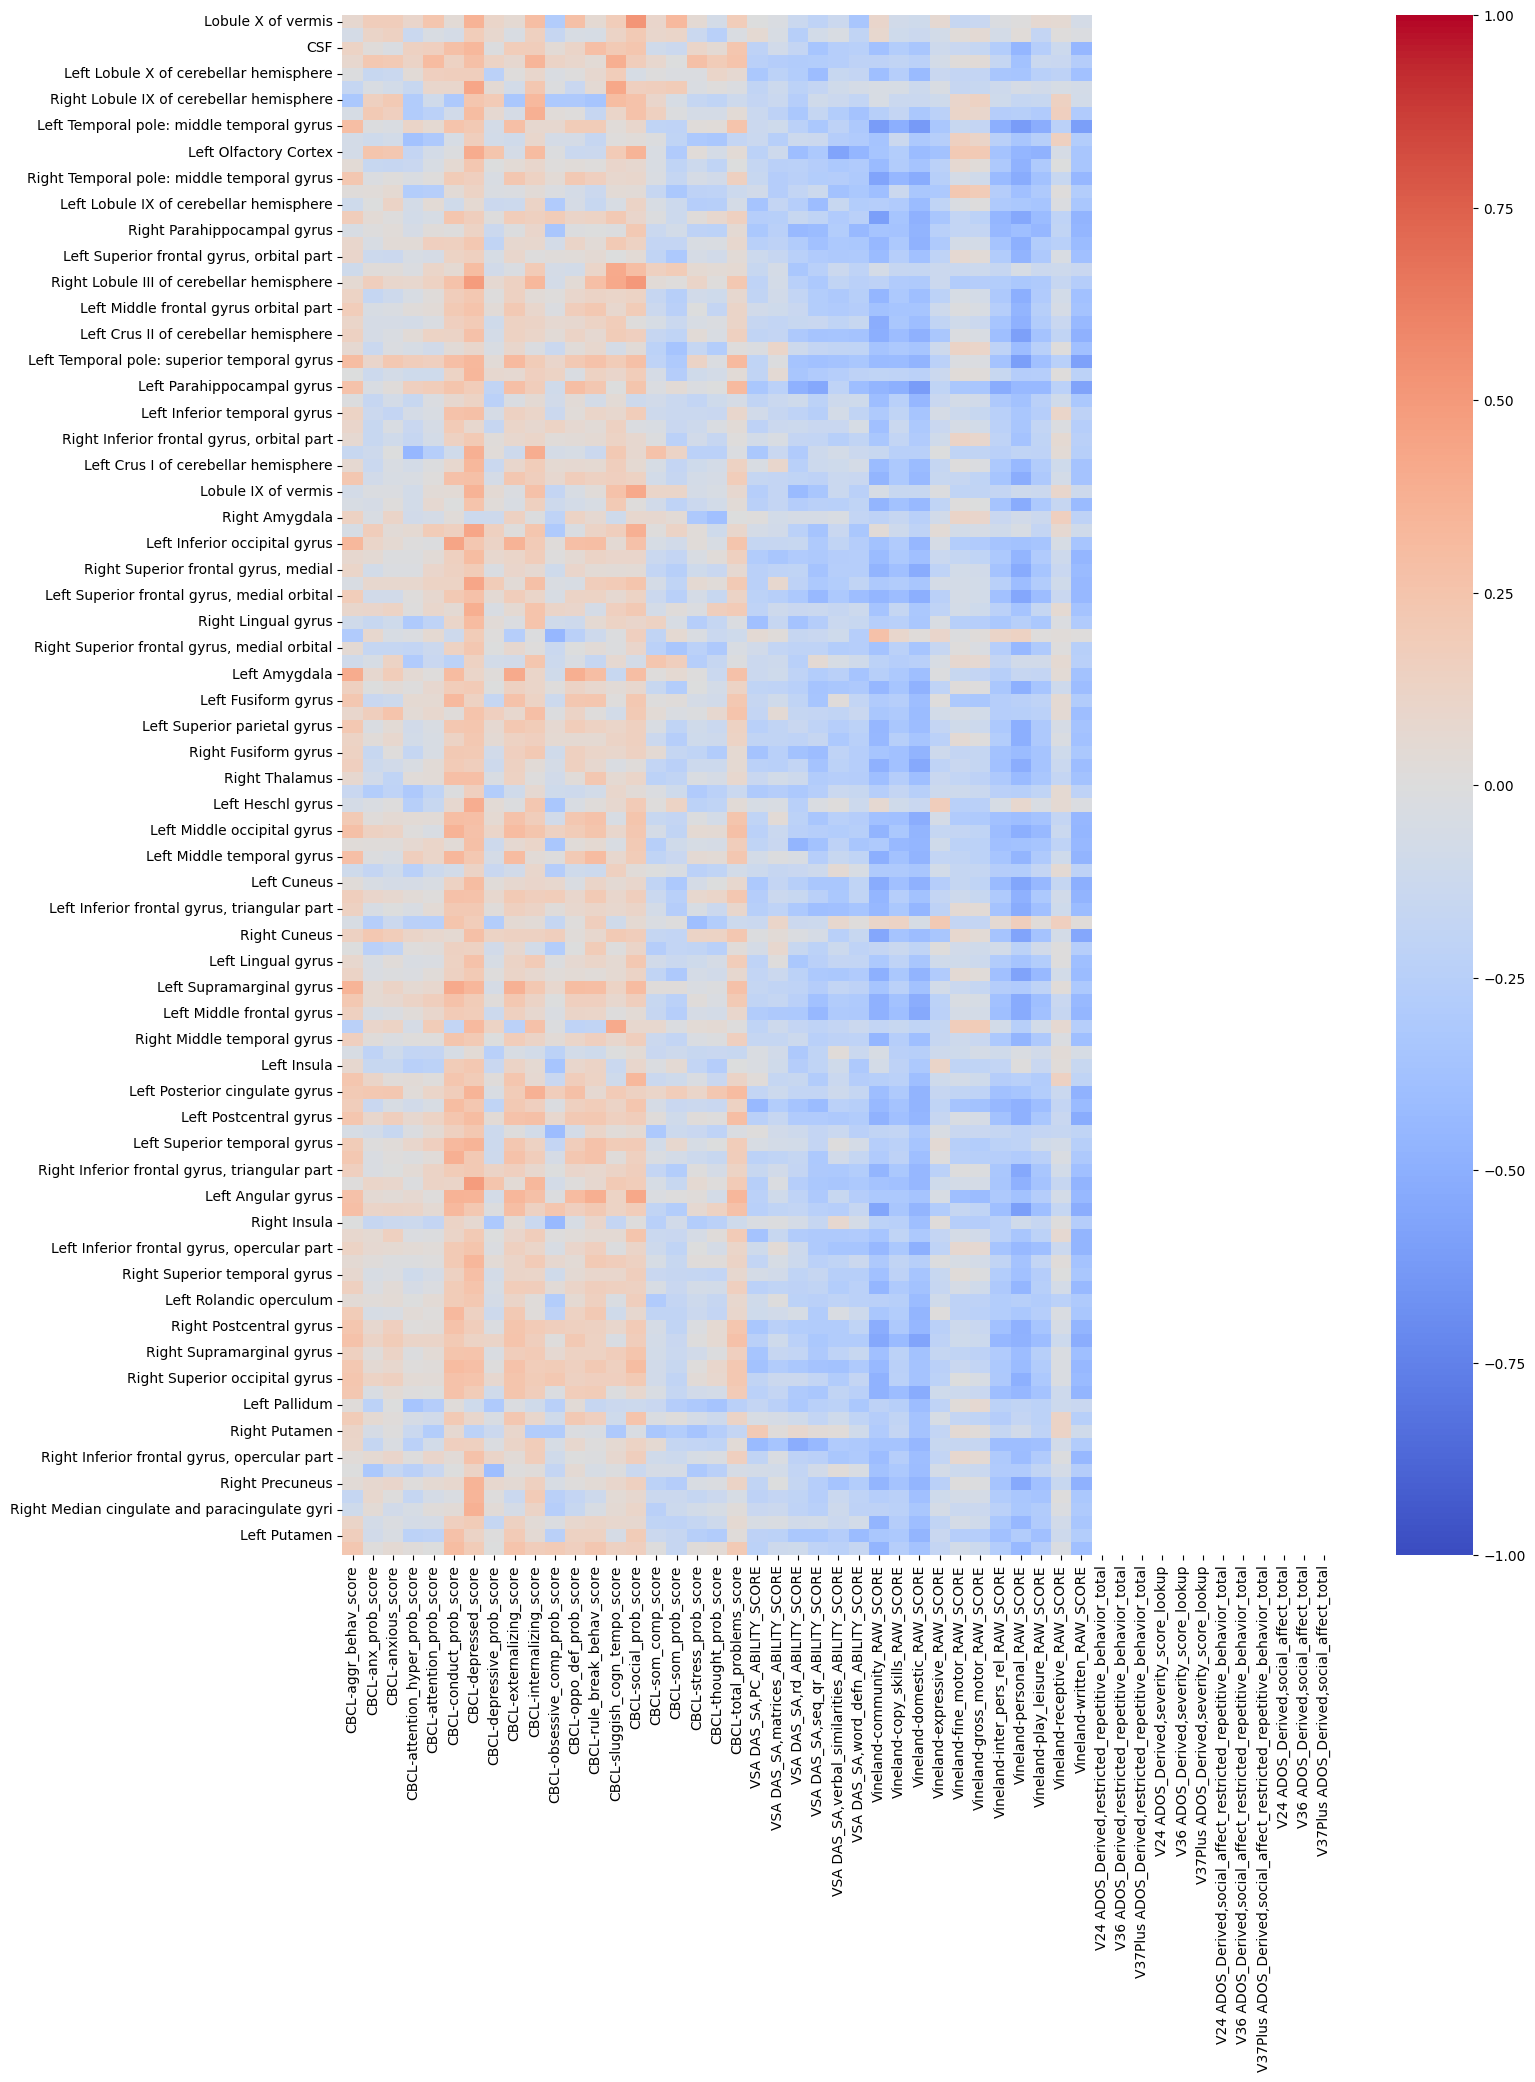

In [17]:
fig, axs = plt.subplots(1,1, figsize=(16,20))
sns.heatmap(cmat, cmap='coolwarm', vmin=-1, vmax=1, ax=axs)
# sns.heatmap(pvalues, ax=axs[1])
plt.show()

# pval = 0.01
# significant = pvalues < pval
# sns.heatmap(corrmatrix[significant].loc[behavior_cols, sorted_roi_columns],  cmap='coolwarm',
#             vmin=-1, vmax=1, )
# plt.title(f"Correlations with pvalues below {pval}");

# Analyzing DS-Prototype Samples 

#### Grabbing DS ROI likelihoods and merging with metadata

In [19]:
dssamples = datadf.query("Cohort == 'IBIS-DS'")
ds_metadata = pd.read_csv("/ASD/ahsan_projects/braintypicality/dataset/ds_metadata.csv").replace(np.nan, 0)
ds_metadata['ASD-Cutoff'] = ds_metadata['MetASDCutOff'].map({0: False, 1: True})
ds_metadata['ID'] = "IBIS" + ds_metadata['CandID'].astype(str)
dssamples = pd.merge(dssamples, ds_metadata, on='ID')
dssamples.head(2)

,Background,CSF,Left Precentral gyrus,Right Precentral gyrus,"Left Superior frontal gyrus, dorsolateral","Right Superior frontal gyrus, dorsolateral","Left Superior frontal gyrus, orbital part","Right Superior frontal gyrus, orbital part",Left Middle frontal gyrus,Right Middle frontal gyrus,...,SATotalMod3,MetASDCutOff,CandID_y,"VSA demographics,ASD_Ever_DSMIV","VSA demographics,ASD_Ever_DSMV","VSA demographics,Age_at_visit_start","VSA demographics,Risk","VSA demographics,Sex","VSA demographics,candidate_race",ASD-Cutoff
0,-38.342600,3.548188,-11.646181,-9.907785,-7.934814,-9.100883,-2.757597,-2.158922,-9.024731,-8.604287,...,#NULL!,0.0,105477,ASD-,ASD-,136.0,0.0,Female,white,False
1,-42.486153,1.753893,-15.714825,-14.254395,-11.120783,-10.769796,-3.553080,-1.557293,-11.703229,-9.776938,...,#NULL!,1.0,110925,ASD+ (VSA),ASD-,116.0,0.0,Male,white,True


### Protoypes are retrieved from prerun SOM labels (via `down_syndrome_som.ipynb`)

In [20]:
ds_bmu_ids = pd.read_csv("data/ds_prototypes_11x11.csv")
largest_prototype_bmu_idx = ds_bmu_ids.groupby('bmu').count().idxmax()[0]
ds_max_prototype_ids = ds_bmu_ids[ds_bmu_ids.bmu == largest_prototype_bmu_idx]['ID']
prot_ids_set = set(ds_max_prototype_ids)

ds_prototypes = dssamples.merge(ds_max_prototype_ids, on='ID')
ds_non_prototypes = dssamples[~dssamples['ID'].isin(ds_max_prototype_ids)]
len(ds_prototypes), len(ds_non_prototypes)

(16, 12)

In [21]:
dssamples.loc[:, 'Subpopulation'] = dssamples['ID'].isin(prot_ids_set)
dssamples.loc[:, 'Subpopulation'] = dssamples['Subpopulation'].map({True:"Maximal-Prototype", False: "Non-Prototype"})
dssamples['Subpopulation'].value_counts()

Maximal-Prototype    16
Non-Prototype        12
Name: Subpopulation, dtype: int64

In [22]:
plotdf = dssamples.melt(id_vars=['Sex', 'Subpopulation', 'ASD-Cutoff'], var_name='ROI', value_name='Anomaly Score')
plotdf = plotdf[plotdf['ROI'].isin(roi_columns)]
plotdf['Anomaly Score'] = plotdf['Anomaly Score'].astype(float)
plotdf = plotdf.sort_values(by='Anomaly Score')

<Axes: xlabel='Anomaly Score', ylabel='Count'>

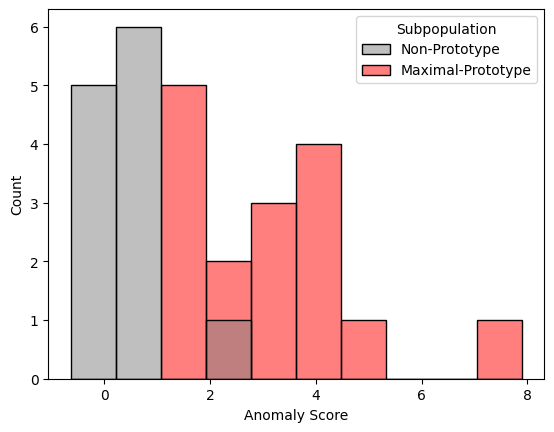

In [23]:
sns.histplot(data=plotdf.query("ROI == 'CSF'"), x='Anomaly Score',
             hue='Subpopulation', bins=10, legend=True, palette=['gray', 'red'])

In [24]:
# Set the axis title font size using rcParams
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['figure.titlesize'] = 20
# plt.rcParams['axes.titlesize'] = 16
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 20, "axes.titlesize":22})

### Sample 11 has missing values and 15 is an outlier in `depressed_percentile`

In [25]:
ds_prototypes[behavior_cols]

,CBCL-aggr_behav_score,CBCL-anx_prob_score,CBCL-anxious_score,CBCL-attention_hyper_prob_score,CBCL-attention_prob_score,CBCL-conduct_prob_score,CBCL-depressed_score,CBCL-depressive_prob_score,CBCL-externalizing_score,CBCL-internalizing_score,...,"V37Plus ADOS_Derived,restricted_repetitive_behavior_total","V24 ADOS_Derived,severity_score_lookup","V36 ADOS_Derived,severity_score_lookup","V37Plus ADOS_Derived,severity_score_lookup","V24 ADOS_Derived,social_affect_restricted_repetitive_behavior_total","V36 ADOS_Derived,social_affect_restricted_repetitive_behavior_total","V37Plus ADOS_Derived,social_affect_restricted_repetitive_behavior_total","V24 ADOS_Derived,social_affect_total","V36 ADOS_Derived,social_affect_total","V37Plus ADOS_Derived,social_affect_total"
0,11.0,4.0,3.0,5.0,6.0,2.0,2.0,3.0,13.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2.0,1.0,0.0,3.0,4.0,0.0,0.0,1.0,2.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,11.0,4.0,2.0,6.0,8.0,3.0,0.0,3.0,14.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,6.0,0.0,0.0,5.0,10.0,2.0,0.0,1.0,7.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,5.0,1.0,1.0,5.0,6.0,1.0,0.0,0.0,7.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,6.0,2.0,2.0,12.0,13.0,1.0,0.0,3.0,7.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,6.0,3.0,1.0,6.0,7.0,4.0,0.0,0.0,10.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,8.0,0.0,0.0,6.0,7.0,5.0,1.0,1.0,13.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,1.0,1.0,1.0,1.0,4.0,1.0,3.0,1.0,2.0,6.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,17.0,6.0,4.0,8.0,12.0,8.0,2.0,2.0,22.0,9.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Prototype Correlation analysis is done wrt Prototype-significant brain ROIs and all Behavior scores 

In [26]:
# np.random.seed(42)
# non_numeric_cols = ['Cohort', 'ID', 'Identifiers', 'Sex']
# sigcorrdf = run_correlation_analysis(ds_prototypes,
#                                                            behavior_cols=behavior_cols,
#                                                            relevant_roi_columns=list(roi_columns),
#                                                            n_resamples=20_000)

In [27]:
# sigcorrdf.to_csv("data/full-corr_pvals.csv")

In [28]:
sigcorrdf = pd.read_csv("data/full-corr_pvals.csv", index_col=0)

sigcorrdf['adjusted-p'] = false_discovery_control(sigcorrdf['p-value'], method='bh')
alpha = 0.01
print(f"Significant: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['p-value'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.05
print(f"Significant: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['p-value'] < alpha).sum()} / {len(sigcorrdf)}")
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.1
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.3
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
print()
sigcorrdf.head(3)

Significant: 0.01 -> Significant ROI-Behavior Correlations: 66 / 4130
Significant: 0.05 -> Significant ROI-Behavior Correlations: 260 / 4130
FDR: 0.05 -> Significant ROI-Behavior Correlations: 0 / 4130
FDR: 0.1 -> Significant ROI-Behavior Correlations: 0 / 4130
FDR: 0.3 -> Significant ROI-Behavior Correlations: 0 / 4130



,ROI,Behavior,Corr,p-value,nsamples,adjusted-p
0,Background,CBCL-aggr_behav_score,0.121056,0.666767,15,0.982987
1,Background,CBCL-anx_prob_score,0.068044,0.817959,15,0.998400
2,Background,CBCL-anxious_score,0.128766,0.649168,15,0.982987


In [29]:
len(sigcorrdf.Behavior.unique())

35

In [30]:
sigcorrdf.shape

(4130, 6)

### Which Assessment shows high correlation with MSMA scores?

In [31]:
sum(sigcorrdf['p-value'] < 0.01)

66

In [32]:
ref_max = reference_likelihoods.quantile(0.99)
pmask = sigcorrdf['p-value'] < (FIVE_PERCENT)
corrmask = (sigcorrdf['Corr'].abs() > 0.7) & pmask
print("Above correlation thresh:", corrmask.sum())
sigcorrdf[corrmask].groupby('Behavior').describe()['Corr']

Above correlation thresh: 39


,count,mean,std,min,25%,50%,75%,max
Behavior,,,,,,,,
CBCL-depressed_score,12.0,0.744307,0.050422,0.704181,0.707512,0.719406,0.784115,0.860243
CBCL-internalizing_score,1.0,0.737178,NaN,0.737178,0.737178,0.737178,0.737178,0.737178
CBCL-sluggish_cogn_tempo_score,2.0,0.765223,0.046812,0.732122,0.748672,0.765223,0.781774,0.798324
"VSA DAS_SA,rd_ABILITY_SCORE",20.0,-0.751958,0.044550,-0.850195,-0.777857,-0.741242,-0.720701,-0.700161
Vineland-copy_skills_RAW_SCORE,1.0,-0.713776,NaN,-0.713776,-0.713776,-0.713776,-0.713776,-0.713776
Vineland-domestic_RAW_SCORE,3.0,-0.757472,0.043800,-0.795704,-0.781367,-0.767030,-0.738356,-0.709682


/tmp/ipykernel_1487149/196749314.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(rowdf, x=roi, y=bhv, palette='tab10', s=200, alpha=1)


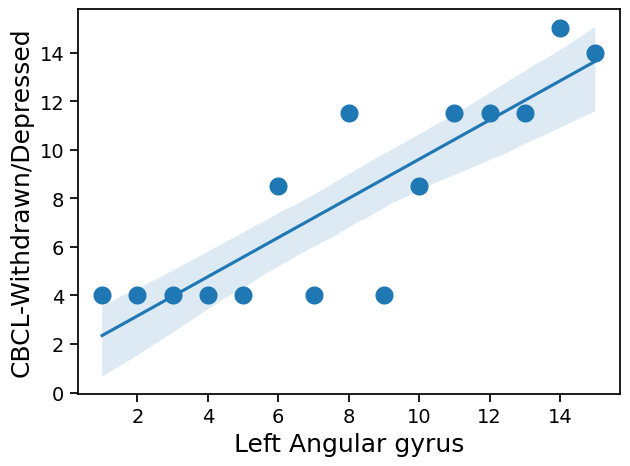

In [33]:
sns.set_context("notebook", font_scale=2, rc={"axes.labelsize": 18,
                                                "axes.titlesize":18,
                                                'axes.labelweight':'bold',
                                                'xtick.labelsize': 14,
                                                'ytick.labelsize': 14
                                               })
roi,bhv = "Left Angular gyrus", "CBCL-depressed_score"
rowdf = ds_prototypes.copy()
m = rowdf[bhv] > -1
rowdf = rowdf[m]
rowdf[[roi, bhv]] = rowdf[[roi, bhv]].apply(rankdata)

fig, axs = plt.subplots(1,1, figsize=(7,5))
sns.scatterplot(rowdf, x=roi, y=bhv, palette='tab10', s=200, alpha=1)
sns.regplot(rowdf, x=roi, y=bhv)
spearmanr(rowdf[roi], rowdf[bhv])
plt.ylabel(behavior_column_map[bhv])
plt.savefig('figures/single-corr.png', transparent=True, bbox_inches='tight')

In [34]:
sns.set_context("notebook", font_scale=2, rc={"axes.labelsize": 32,
                                                "axes.titlesize":22,
                                                'axes.labelweight':'bold',
                                                'xtick.labelsize': 20,
                                                'ytick.labelsize': 20
                                               
                                               })

def plot_correlations(rows, fig, axs):
    show_legend = True

    for ax, row in zip(axs.flat, rows_df):
        ax.set_ymargin(0.01)
        idx, (roi, bhv, corr, p, n, ap) = row
        non_missing_samples = ds_prototypes[bhv] > -1
        points_df = ds_prototypes[non_missing_samples].copy()

        points_df[[roi, bhv]] = points_df[[roi, bhv]].apply(rankdata)

        sns.scatterplot(points_df, x=roi, y=bhv, style='Sex', hue='Sex',
                        palette='tab10', markers=['P','v'],
                        ax=ax, legend=show_legend, s=500, alpha=1)
        sns.regplot(points_df, x=roi, y=bhv, scatter=False,
                    color='black', ci=None, robust=True, truncate=True, ax=ax)

        ymin,ymax = ax.get_ylim()
        offset = 0.1*(ymax-ymin)

        ymin = np.clip(ymin-offset, -offset, None)
        ymax += offset
        ax.set_ylim(ymin, ymax)

    #     ax.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
        ax.set(ylabel= behavior_column_map.get(bhv, bhv))

        ytext = 0.8
        xtext = 0.05 if corr > 0 else 0.75
        text_box = ax.text(xtext, ytext, f"r = {corr:.3f}\np < {np.clip(p, 1e-3, None):.3f}", 
                           transform=ax.transAxes,
                           fontsize=32, color='white',
                           bbox={'facecolor':'tab:blue', 'alpha':0.5,
                                 'boxstyle':"round,pad=0.3"}
                          )

        if show_legend:
            show_legend = False
            fig.legend(loc='upper right', fontsize='x-large', ncols=1, bbox_to_anchor=(1, 1.05))
            l = ax.legend()
            l.set_visible(False)

pthresh, corrthresh = ONE_PERCENT, 0.7
plotmask = (sigcorrdf['Corr'].abs() > corrthresh) & (sigcorrdf['p-value'] <= pthresh)

nrows, ncols = 6, 3
rows_df = list(sigcorrdf[plotmask].sort_values(by='p-value').iterrows())
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*8),)
plot_correlations(rows_df, fig, axs)
plt.tight_layout(h_pad=2)
plt.savefig(f'figures/subset-regplot-corr={corrthresh}-p={pthresh}.pdf', dpi=150, bbox_inches='tight')
plt.close()

# fig, axs = plt.subplots(4,4, figsize=(48, 36),)
# plot_correlations(rows_df[nrows*ncols:], fig, axs)
# plt.tight_layout(h_pad=2)
# plt.savefig('figures/subset-rest-regplot-corr={corrthresh}-p={pthresh}.pdf'', dpi=150, bbox_inches='tight')
# plt.close()

In [40]:
sigcorrdf[plotmask]

,ROI,Behavior,Corr,p-value,nsamples,adjusted-p
6,Background,CBCL-depressed_score,0.595699,0.021899,15,0.608068
22,Background,"VSA DAS_SA,rd_ABILITY_SCORE",-0.775178,0.004500,12,0.598521
41,CSF,CBCL-depressed_score,0.654698,0.011599,15,0.598521
111,Left Angular gyrus,CBCL-depressed_score,0.860243,0.000200,15,0.598521
114,Left Angular gyrus,CBCL-internalizing_score,0.686588,0.005600,15,0.598521
...,...,...,...,...,...,...
4053,Right Temporal pole: middle temporal gyrus,Vineland-domestic_RAW_SCORE,-0.709682,0.004300,15,0.598521
4066,Right Temporal pole: superior temporal gyrus,CBCL-depressed_score,0.648988,0.011799,15,0.598521
4069,Right Temporal pole: superior temporal gyrus,CBCL-internalizing_score,0.531202,0.043198,15,0.759179
4082,Right Temporal pole: superior temporal gyrus,"VSA DAS_SA,rd_ABILITY_SCORE",-0.764461,0.005400,12,0.598521


In [37]:
pthresh, corrthresh = FIVE_PERCENT, 0
plotmask = (sigcorrdf['p-value'] < pthresh)

nrows, ncols = 8, 4
nplots = plotmask.sum()
plots_per_fig = nrows*ncols
rows_df = list(sigcorrdf[plotmask].iterrows())


for i in range(nplots // plots_per_fig):
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*8),)
    plot_correlations(rows_df[plots_per_fig*i:], fig, axs)
    plt.tight_layout(h_pad=2)
    plt.savefig(f'figures/full-{i}-regplot-p={pthresh}.pdf', dpi=150, bbox_inches='tight')
    plt.close()

In [38]:
pmatrix = pd.DataFrame()
corrmatrix = pd.DataFrame()

for row in sigcorrdf.iterrows():
    idx, (roi, bhv, corr, p, n, ap) = row
    pmatrix.loc[roi, bhv] = p
    pmatrix.loc[bhv, roi] = p
    
    corrmatrix.loc[roi, bhv] = corr
    corrmatrix.loc[bhv, roi] = corr

/tmp/ipykernel_1487149/3966580699.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pmatrix.loc[bhv, roi] = p
/tmp/ipykernel_1487149/3966580699.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  corrmatrix.loc[bhv, roi] = corr
/tmp/ipykernel_1487149/3966580699.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

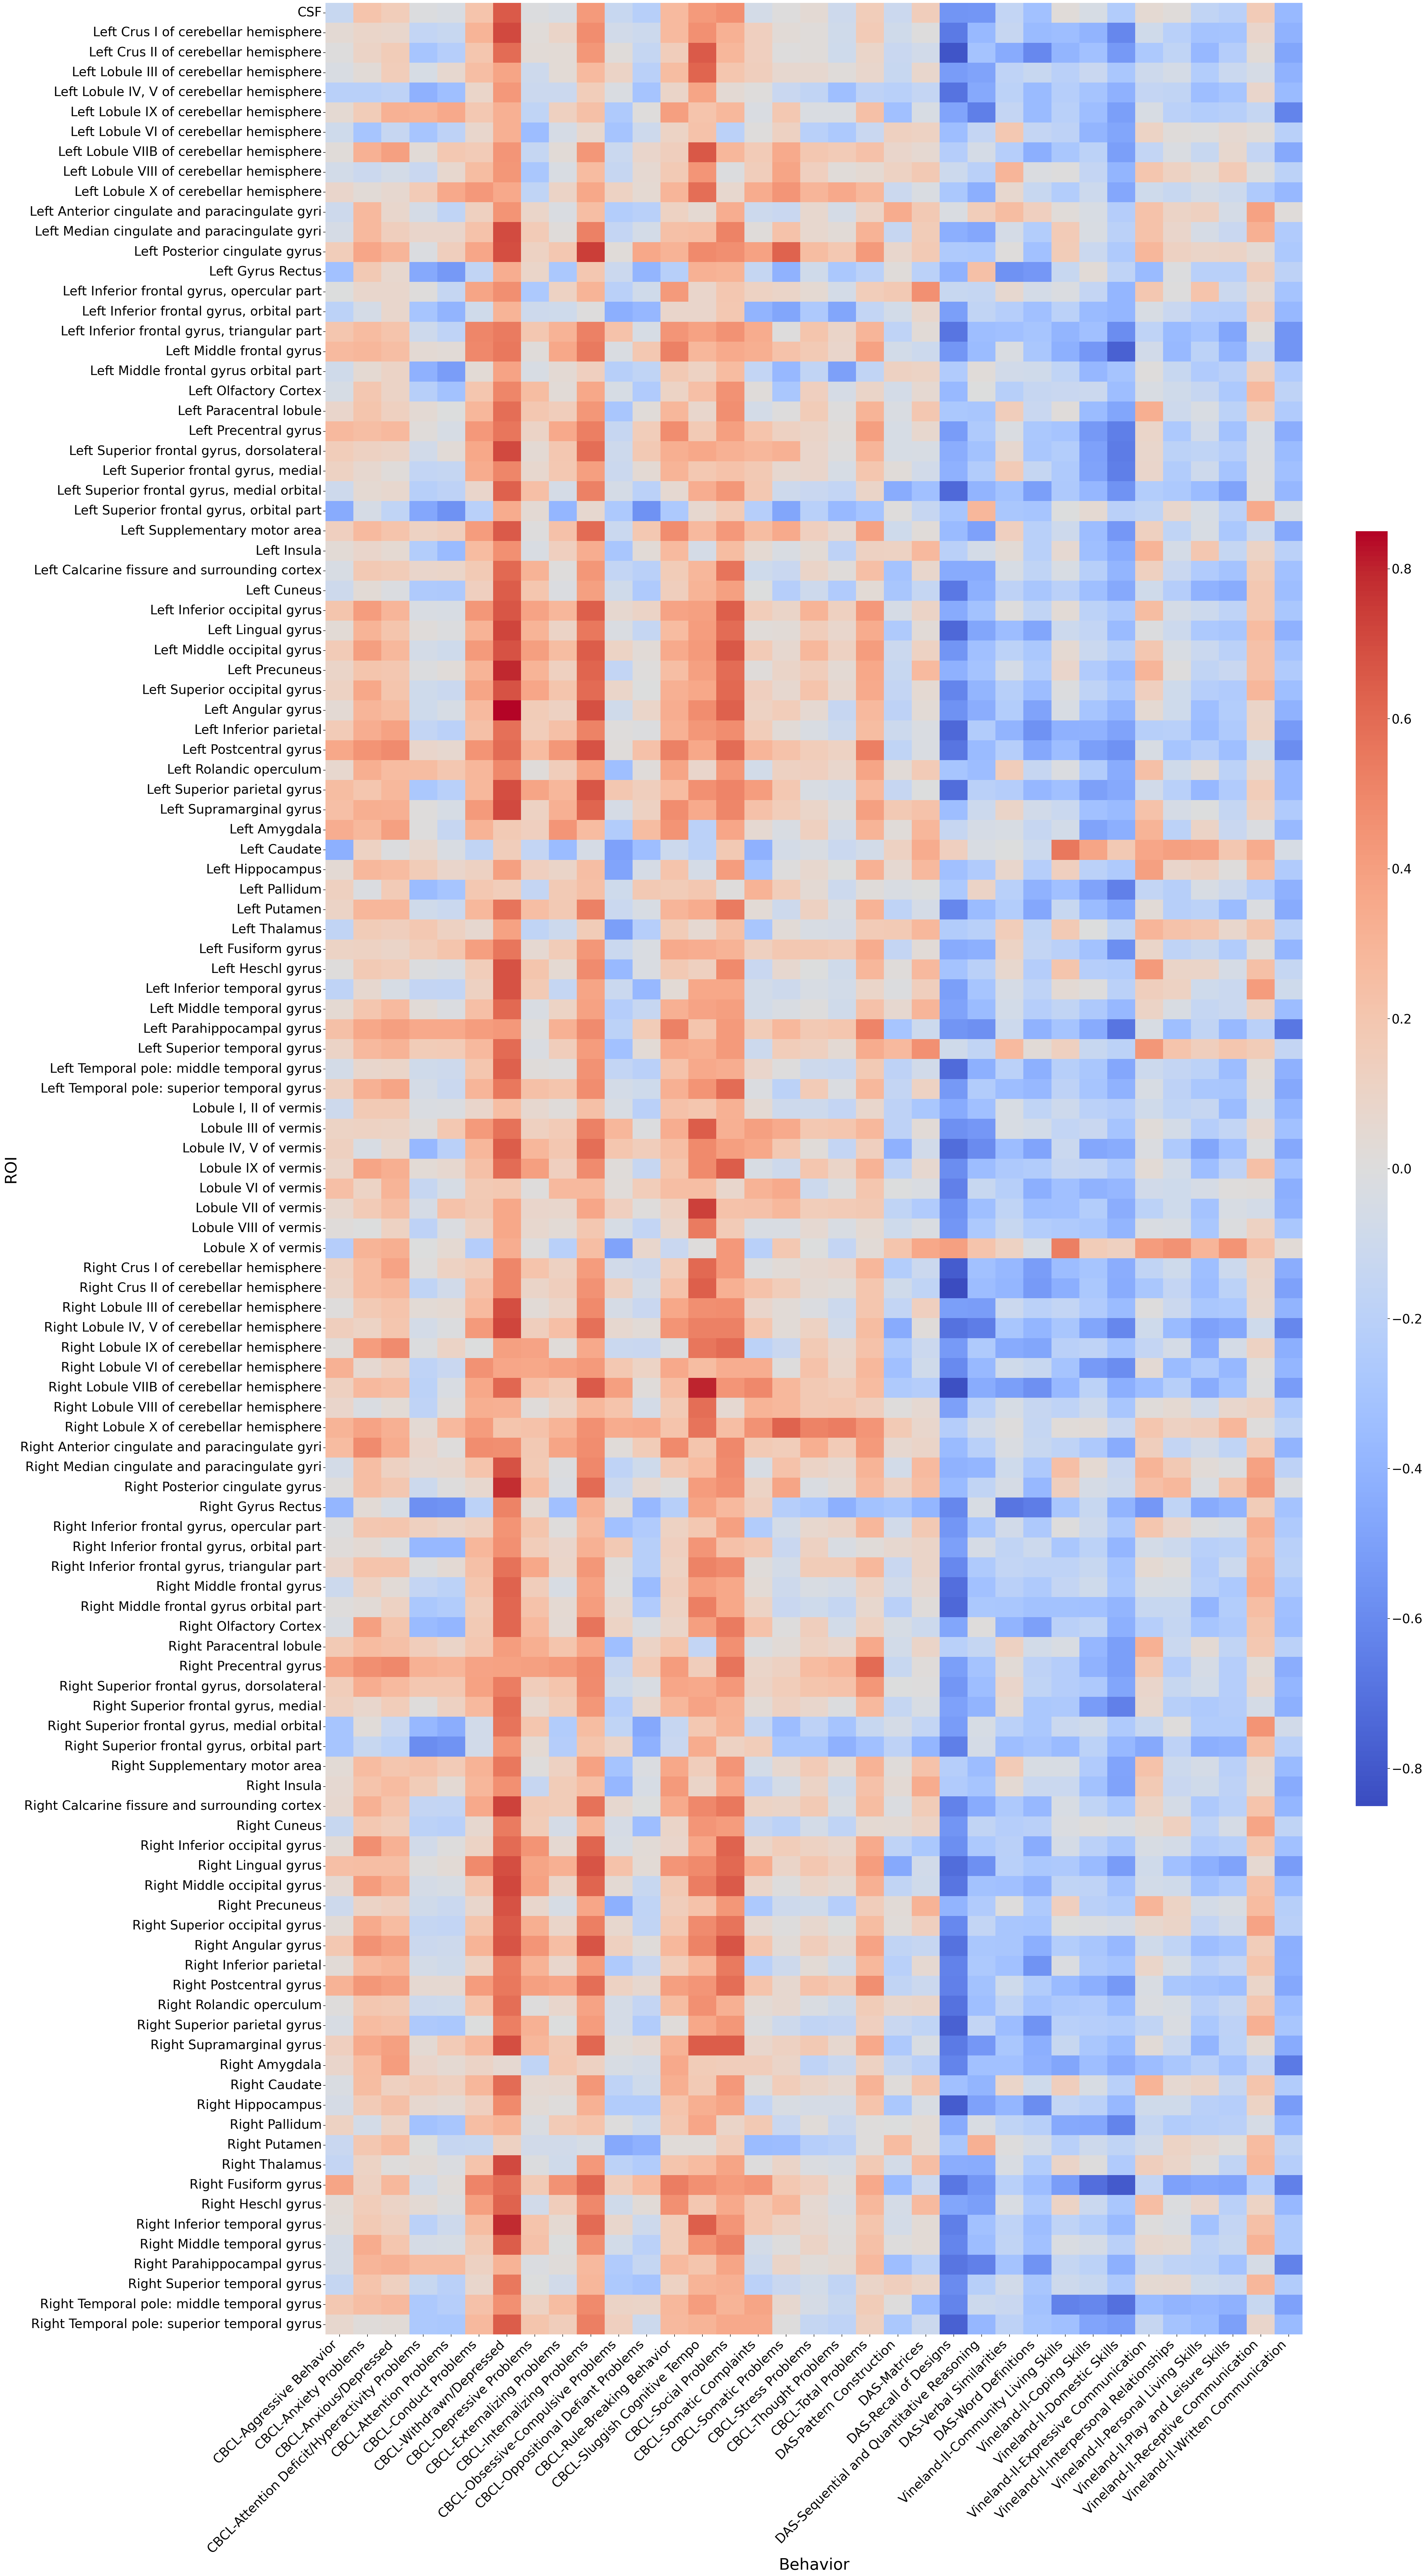

In [42]:
sns.set_context("notebook", font_scale=1.75, rc={"axes.labelsize": 40,
                                                "axes.titlesize":42,
                                                'axes.labelweight':'bold',
                                                'xtick.labelsize': 32,
                                                'ytick.labelsize': 32
                                               })
fig, axs = plt.subplots(1,1, figsize=(50,90))

relevant_behaviors = sigcorrdf.Behavior.unique()
# sorted_rois = corrmatrix.loc[list(roi_columns)].mean(1).sort_values(ascending=False).index
sorted_rois = lobe_ordered_rois
# sorted_rois.remove("Background")

m = corrmatrix.loc[sorted_rois, relevant_behaviors].rename(columns=behavior_column_map)
sns.heatmap(m, cmap='coolwarm', vmin=-0.85, vmax=0.85, ax=axs, annot=False,
            cbar_kws={'fraction':0.03, 'aspect':40})

# axs.set_title(f"Correlation Matrix")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
# plt.savefig('figures/full_corrmatrix.pdf', dpi=150)
# plt.close()

# fig, axs = plt.subplots(1,1, figsize=(90,30))
# m = corrmatrix.loc[sorted_rois, relevant_behaviors].rename(columns=behavior_column_map)
# sns.heatmap(m.T, cmap='coolwarm', vmin=-0.85, vmax=0.85, ax=axs, annot=False,
#             cbar_kws={'fraction':0.08, 'aspect':30})

# # axs.set_title(f"Correlation Matrix")
# plt.xticks(rotation=45, ha='right');
# plt.ylabel("Behavior")
# plt.xlabel("ROI")
# plt.tight_layout()
# plt.savefig('figures/full_corrmatrix-landscape.pdf', dpi=150)
# plt.close()

### p-value Matrix

In [43]:
sigcorrdf['p-value'].dropna().quantile([0.01, 0.1])

0.01    0.007000
0.10    0.085696
Name: p-value, dtype: float64

In [44]:
fig, axs = plt.subplots(1,1, figsize=(42,80))
pmax = thresh = FIVE_PERCENT
pmin = 0.001
log_norm = LogNorm(vmin=pmin, vmax=pmax)
m = pmatrix.loc[sorted_rois, relevant_behaviors].rename(columns=behavior_column_map)
significant_ps = m < thresh

sns.heatmap(m*significant_ps, ax=axs, annot=False,
            fmt=".3f",
            norm=log_norm,
            mask=~significant_ps,
#             vmin=0.001, vmax=0.1,
            cmap='rocket', 
            cbar_kws={'ticks': [0.001, 0.005, 0.01, 0.05],
                      'extend':'max', 'format': '%.3f',
                     'fraction':0.05, 'aspect':30
                     }
           )
axs.set_facecolor("seashell")
# axs.set_title(f"Raw p-values below {thresh}")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig('figures/full-pmatrix.pdf', dpi=150)
plt.close()

In [ ]:
sigcorrdf.Corr.describe()

In [ ]:
ax.get_xticklabels(), plotmatrix.columns

In [ ]:
sns.set_context("notebook", font_scale=1.75, rc={"axes.labelsize": 32,
                                                "axes.titlesize":48,
                                                'axes.labelweight':'bold',
                                                'xtick.labelsize': 42,
                                                'ytick.labelsize': 42
                                               },
               )
pthresh, corrthresh = FIVE_PERCENT, 0.2
plotmatrix = corrmatrix.loc[sorted_rois, relevant_behaviors]

mask = (pmatrix.loc[sorted_rois, relevant_behaviors] < pthresh) & \
       (corrmatrix.loc[sorted_rois, relevant_behaviors].abs() > corrthresh)

plotregions = mask.index[mask.any(axis='columns')].to_list()
plotbhv = mask.columns[mask.any(axis='rows')].to_list()

plotmatrix = corrmatrix.loc[sorted_rois, relevant_behaviors].copy()
plotmatrix = plotmatrix.loc[plotregions, plotbhv].rename(columns=behavior_column_map)
plotmask = ~mask.loc[plotregions, plotbhv].values


# fig, ax = plt.subplots(1,1, figsize=(50,90))

# sns.heatmap(plotmatrix, mask=plotmask,
#              cmap='coolwarm', vmin=-0.85, vmax=0.85,
#             ax=ax, annot=True, fmt='.2f', annot_kws={"size": 36},
#             cbar_kws={'fraction':0.03,'aspect':40}
#            )

# plt.xticks(rotation=45, ha='right')

# # # Create a twin axis
# # ax_top = ax.twiny()

# # # Set the tick locations and labels for the top axis
# # ax_top.set_xticks(ax.get_xticks(), labels = plotmatrix.columns)
# # # ax_top.set_xbound(ax.get_xbound())
# # # ax_top.set_xticklabels(ax.get_xticklabels()
# # plt.xticks(rotation=35, ha='center', fontsize=30)

# plt.xlabel("Behavior")
# plt.ylabel("ROI")
# plt.tight_layout()

# plt.savefig(f'figures/subset-corrmatrix-corr={corrthresh}-p={pthresh}.pdf', dpi=150)
# plt.close()

fig, axs = plt.subplots(1,1, figsize=(150,45))

sns.heatmap(plotmatrix.T, mask=plotmask.T,
             cmap='coolwarm', vmin=-0.85, vmax=0.85,
            ax=axs, annot=True, fmt='.2f',
            cbar_kws={'fraction':0.05, 'aspect':40, 'location': 'top'},
            annot_kws={"size": 36},
           )

plt.xticks(rotation=45, ha='right');
plt.ylabel("Behavior")
plt.xlabel("ROI")
plt.tight_layout()
plt.savefig(f'figures/subset-corrmatrix-corr={corrthresh}-p={pthresh}-landscape.pdf', dpi=150)
plt.close()

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(18,6))
# sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
# axs[0].set_xticks([])
thresh = TEN_PERCENT * 3
relcorrs = sigcorrdf[sigcorrdf['adjusted-p'] < thresh]
# corrs = corrmatrix[corrected_pmatrix < TEN_PERCENT].loc[relcorrs['ROI'].unique(), relcorrs['Behavior'].unique()]
# relevant_behaviors = corrs.count(axis=0)[corrs.count(axis=0) > 0].sort_values(ascending=False).index
# relevant_rois = corrs.count(axis=1)[corrs.count(axis=1) > 0].sort_values(ascending=False).index
relevant_behaviors, relevant_rois = relcorrs['Behavior'].unique(), relcorrs['ROI'].unique()

sns.heatmap(corrmatrix[corrected_pmatrix < thresh].loc[relevant_behaviors, relevant_rois],
            annot=True,
            cmap='coolwarm', vmin=-1, vmax=1, ax=axs,)
# axs.set_title(f"Significant Correlations (corrected-p < {TEN_PERCENT})", pad=20)
plt.xticks(rotation=35, ha='right');
plt.ylabel("Behavior")
plt.xlabel("ROI")
plt.tight_layout()
# plt.savefig('figures/corrected_sig_roi_corrs.pdf', dpi=150)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

thresh = 0.01
relcorrs = sigcorrdf[sigcorrdf['p-value'] < thresh]
relcorrs.groupby('Behavior')['ROI'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[0])

axs[0].set_title(f"Count of Significant Behaviors")
# plt.xticks(rotation=45, ha='right');

relcorrs.groupby('ROI')['Behavior'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[1])
axs[1].set_title(f"Count of Significant ROIs")
# axs[1].set_xticks(rotation=45, ha='right');
plt.tight_layout()
# plt.title("Number Behavior/ROIs in a Significant Pair")